In [1]:
#%%
# Cell 1 — Imports & Configuration
import os
import math
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torchvision.transforms as transforms
from transformers import AutoModel, AutoImageProcessor
import timm

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- CONFIG ----------------
class Config:
    # --- Paths and Sizes ---
    BASE_DIR = "dataset_split"   # Your dataset: train/ validation/ test/ folders
    IMG_SIZE = 224
    BATCH_SIZE = 16              # Reduce if OOM
    NUM_WORKERS = 0              # Set to 2 or 4 for local machines

    # --- Model Names ---
    DINO_MODEL = "facebook/dinov2-small"
    EVA_MODEL = "eva02_small_patch14_224.mim_in22k"
    CNN_MODEL = "convnextv2_tiny.fcmae" # Powerful modern CNN
    PROJ_DIM = 768               # Common dimension for projection

    # --- Checkpoint Saving ---
    SAVE_DIR = "checkpoints_triplet_v1"
    os.makedirs(SAVE_DIR, exist_ok=True)

    # --- Training Phases ---
    HEAD_EPOCHS = 6
    PARTIAL_EPOCHS = 18
    FULL_EPOCHS = 50

    # --- Learning Rates ---
    HEAD_LR = 3e-4
    PARTIAL_LR = 5e-5
    FULL_LR = 5e-6

    # --- Training Parameters ---
    WEIGHT_DECAY = 0.05
    LR_WARMUP_EPOCHS = 3
    PATIENCE = 8                 # Patience for early stopping
    MIXUP_ALPHA = 0.3
    SPEC_AUG_FREQ = 20
    SPEC_AUG_TIME = 30
    DROP_RATE = 0.4

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config()
print("Device:", config.DEVICE)
print("Dataset base dir:", config.BASE_DIR)
print("Save directory:", config.SAVE_DIR)




Device: cuda
Dataset base dir: dataset_split
Save directory: checkpoints_triplet_v1


In [2]:
#%%
# Cell 2 — NEW: Triplet Hybrid Model (EVA02 + DinoV2 + CNN)
class TripletHybridModel(nn.Module):
    def __init__(self, num_classes, proj_dim=768, drop_rate=0.4,
                 dino_name=config.DINO_MODEL,
                 eva_name=config.EVA_MODEL,
                 cnn_name=config.CNN_MODEL):

        super().__init__()
        self.proj_dim = proj_dim

        # --- 1. DinoV2 Branch (for token features) ---
        print(f"Loading {dino_name}")
        self.dino_backbone = AutoModel.from_pretrained(dino_name)
        dino_dim = self.dino_backbone.config.hidden_size # e.g., 384 for small
        self.dino_proj = nn.Sequential(
            nn.LayerNorm(dino_dim),
            nn.Linear(dino_dim, proj_dim)
        )

        # --- 2. EVA02 Branch (for pooled features) ---
        print(f"Loading {eva_name}")
        self.eva_backbone = timm.create_model(
            eva_name,
            pretrained=True,
            num_classes=0,       # Remove classifier
            global_pool='avg'    # Get pooled output
        )
        eva_dim = self.eva_backbone.num_features # e.g., 384 for small
        self.eva_proj = nn.Sequential(
            nn.LayerNorm(eva_dim),
            nn.Linear(eva_dim, proj_dim)
        )

        # --- 3. CNN Branch (for pooled features) ---
        print(f"Loading {cnn_name}")
        self.cnn_backbone = timm.create_model(
            cnn_name,
            pretrained=True,
            num_classes=0,
            global_pool='avg'
        )
        cnn_dim = self.cnn_backbone.num_features # e.g., 768 for tiny
        self.cnn_proj = nn.Sequential(
            nn.LayerNorm(cnn_dim),
            nn.Linear(cnn_dim, proj_dim)
        )

        # --- 4. Fusion Head ---
        # We concatenate three projected features
        fusion_in_dim = proj_dim * 3
        self.fusion_head = nn.Sequential(
            nn.LayerNorm(fusion_in_dim),
            nn.Linear(fusion_in_dim, 1024),
            nn.GELU(),
            nn.Dropout(drop_rate),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(drop_rate * 0.5),
            nn.Linear(512, num_classes)
        )
        print("TripletHybridModel created.")

    def forward(self, x):
        # --- 1. DinoV2 ---
        # Get token features and average them
        # Note: .train() / .eval() and torch.no_grad() in the validation
        # loop will handle freezing, no need for logic here.
        dino_tokens = self.dino_backbone(pixel_values=x).last_hidden_state
        dino_pooled = torch.mean(dino_tokens, dim=1) # [B, N, C] -> [B, C]
        dino_feat = self.dino_proj(dino_pooled)

        # --- 2. EVA02 ---
        eva_pooled = self.eva_backbone(x)
        eva_feat = self.eva_proj(eva_pooled)

        # --- 3. CNN ---
        cnn_pooled = self.cnn_backbone(x)
        cnn_feat = self.cnn_proj(cnn_pooled)

        # --- 4. Fusion ---
        fused_features = torch.cat([dino_feat, eva_feat, cnn_feat], dim=1)
        logits = self.fusion_head(fused_features)

        return logits

    # Helper function to freeze backbones
    def freeze_backbones(self):
        print("Freezing all backbones...")
        for param in self.dino_backbone.parameters():
            param.requires_grad = False
        for param in self.eva_backbone.parameters():
            param.requires_grad = False
        for param in self.cnn_backbone.parameters():
            param.requires_grad = False

    # Helper function to unfreeze all parameters
    def unfreeze_all(self):
        print("Unfreezing all parameters...")
        for param in self.parameters():
            param.requires_grad = True

    # Helper function to unfreeze partial layers (top ones)
    def unfreeze_partial(self):
        print("Unfreezing top layers of backbones...")
        # Unfreeze all projection and fusion layers (should be done by default optimizer)
        for param in self.dino_proj.parameters(): param.requires_grad = True
        for param in self.eva_proj.parameters(): param.requires_grad = True
        for param in self.cnn_proj.parameters(): param.requires_grad = True
        for param in self.fusion_head.parameters(): param.requires_grad = True

        # Unfreeze top layers of DINO
        for name, param in self.dino_backbone.named_parameters():
            if "layer.10" in name or "layer.11" in name or "layernorm" in name:
                param.requires_grad = True

        # Unfreeze top layers of EVA
        for name, param in self.eva_backbone.named_parameters():
             if "blocks.10" in name or "blocks.11" in name or "norm" in name:
                param.requires_grad = True

        # Unfreeze top layers of CNN
        for name, param in self.cnn_backbone.named_parameters():
            if "stages.3" in name or "norm" in name:
                 param.requires_grad = True



In [3]:

#%%
# Cell 3 — Dataset, Transforms, and **Weighted Sampler**
class MelSpectrogramDataset(Dataset):
    def __init__(self, base_dir, split="train", transform=None):
        self.transform = transform
        self.data_dir = os.path.join(base_dir, split)
        if not os.path.isdir(self.data_dir):
            raise FileNotFoundError(f"Directory not found: {self.data_dir}")
        self.classes = sorted([d for d in os.listdir(self.data_dir) if os.path.isdir(os.path.join(self.data_dir, d))])
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}
        self.idx_to_class = {i:c for c,i in self.class_to_idx.items()}
        self.paths, self.labels = [], []
        for cls in self.classes:
            cls_dir = os.path.join(self.data_dir, cls)
            for f in os.listdir(cls_dir):
                if f.lower().endswith((".png",".jpg",".jpeg")):
                    self.paths.append(os.path.join(cls_dir, f))
                    self.labels.append(self.class_to_idx[cls])
        print(f"Found {len(self.paths)} images in {split} with {len(self.classes)} classes.")

    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform: img = self.transform(img)
        return img, label
    
    def get_labels(self):
        return self.labels

# Get normalization stats from DINOv2 processor
proc = AutoImageProcessor.from_pretrained(config.DINO_MODEL)
mean, std = proc.image_mean, proc.image_std

train_transform = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
val_transform = transforms.Compose([
    transforms.Resize((config.IMG_SIZE, config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# --- Create Datasets ---
train_dataset = MelSpectrogramDataset(config.BASE_DIR, "train", train_transform)
val_dataset = MelSpectrogramDataset(config.BASE_DIR, "val", val_transform)
test_dataset = MelSpectrogramDataset(config.BASE_DIR, "test", val_transform)

num_classes = len(train_dataset.classes)
print(f"Total classes: {num_classes}")

# --- **WeightedRandomSampler for Imbalance** ---
print("Setting up WeightedRandomSampler for training...")
# 1. Get all labels from the training dataset
train_labels = train_dataset.get_labels()

# 2. Count occurrences of each class
class_counts = np.bincount(train_labels)
print(f"Class counts: {class_counts}")

# 3. Calculate weights: weight = 1.0 / num_samples_in_class
class_weights = 1. / class_counts
# class_weights = 1. / np.sqrt(class_counts) # Alternative: sqrt smoothing

# 4. Assign a weight to every single sample in the dataset
sample_weights = np.array([class_weights[label] for label in train_labels])
sample_weights = torch.from_numpy(sample_weights).double()

# 5. Create the sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights), # Draw N samples, where N is dataset size
    replacement=True
)

# --- Create DataLoaders ---
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    sampler=sampler,      # <-- Add the sampler
    shuffle=False,        # <-- Sampler and shuffle are mutually exclusive
    num_workers=config.NUM_WORKERS,
    pin_memory=True
)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=True)
print("DataLoaders created.")



Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Found 2825 images in train with 5 classes.
Found 350 images in val with 5 classes.
Found 359 images in test with 5 classes.
Total classes: 5
Setting up WeightedRandomSampler for training...
Class counts: [ 278  751 1436  219  141]
DataLoaders created.


In [4]:

#%%
# Cell 4 — Augment, Mixup, Loss Helpers
class SpecAugment(nn.Module):
    def __init__(self, freq_mask_param=20, time_mask_param=30):
        super().__init__()
        self.F = freq_mask_param
        self.T = time_mask_param
    def forward(self, x):
        B,C,H,W = x.shape
        # freq masks (height)
        f = np.random.randint(0, min(self.F, H)+1)
        if f>0:
            f0 = np.random.randint(0, max(1, H - f))
            x[:, :, f0:f0+f, :] = 0
        # time masks (width)
        t = np.random.randint(0, min(self.T, W)+1)
        if t>0:
            t0 = np.random.randint(0, max(1, W - t))
            x[:, :, :, t0:t0+t] = 0
        return x

spec_augment = SpecAugment(freq_mask_param=config.SPEC_AUG_FREQ, time_mask_param=config.SPEC_AUG_TIME).to(config.DEVICE)

def mixup_data(x, y, alpha=0.3, device="cuda"):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# loss (Gradient Focal Loss from your previous code)
class GradientFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha; self.gamma = gamma; self.reduction = reduction
    def forward(self, logits, targets):
        ce = nn.functional.cross_entropy(logits, targets, reduction="none")
        p = torch.exp(-ce)
        probs = torch.softmax(logits, dim=1)
        target_probs = probs.gather(1, targets.unsqueeze(1)).squeeze(1)
        grad_weight = torch.abs(target_probs - 1.0)
        focal = self.alpha * (1 - p) ** self.gamma * (1 + grad_weight)
        loss = focal * ce
        return loss.mean() if self.reduction=="mean" else loss.sum()



In [5]:

#%%
# Cell 5 — Train and Validation Functions (AMP)
scaler = torch.cuda.amp.GradScaler()
criterion = GradientFocalLoss(alpha=0.25, gamma=2.0).to(config.DEVICE)

def train_epoch(model, dataloader, optimizer, device, mixup_alpha=0.0, spec_aug=True):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []
    pbar = tqdm(dataloader, desc="Train", leave=False)
    for imgs, labels in pbar:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        if spec_aug:
            imgs = spec_augment(imgs)
            
        if mixup_alpha > 0:
            inputs, targets_a, targets_b, lam = mixup_data(imgs, labels, mixup_alpha, device)
        else:
            inputs, targets_a, targets_b, lam = imgs, labels, labels, 1.0

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast():
            logits = model(inputs)
            loss = mixup_criterion(criterion, logits, targets_a, targets_b, lam)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy()) # Use original labels for acc
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = running_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    return avg_loss, acc, f1

def validate_epoch(model, dataloader, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Val", leave=False)
        for imgs, labels in pbar:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            with torch.cuda.amp.autocast():
                logits = model(imgs)
                loss = criterion(logits, labels)
            running_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
            
    avg_loss = running_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    return avg_loss, acc, f1



In [6]:

#%%
# Cell 6 — Phase 1: Train Fusion Head
print("\n--- STARTING PHASE 1: HEAD TRAINING ---")
model = TripletHybridModel(num_classes=num_classes, proj_dim=config.PROJ_DIM, drop_rate=config.DROP_RATE).to(config.DEVICE)

# Freeze backbones, train only projection and fusion layers
model.freeze_backbones()

# Collect parameters that require gradients
opt_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.AdamW(opt_params, lr=config.HEAD_LR, weight_decay=config.WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, config.HEAD_EPOCHS - config.LR_WARMUP_EPOCHS))

best_val_f1 = 0.0
for epoch in range(config.HEAD_EPOCHS):
    print(f"\nHEAD PHASE Epoch {epoch+1}/{config.HEAD_EPOCHS}")
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer, config.DEVICE, mixup_alpha=0.0, spec_aug=True)
    val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, config.DEVICE)
    scheduler.step()
    
    print(f"Train Loss {train_loss:.4f} Acc {train_acc:.4f} F1 {train_f1:.4f}")
    print(f"Val Loss   {val_loss:.4f} Acc {val_acc:.4f} F1 {val_f1:.4f}")
    
    # Save based on best Macro F1-Score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        save_path = os.path.join(config.SAVE_DIR, "best_head_triplet.pth")
        torch.save(model.state_dict(), save_path)
        print(f"Saved best head model to {save_path} (F1: {val_f1:.4f})")

print(f"Head training done. Best val F1: {best_val_f1:.4f}")




--- STARTING PHASE 1: HEAD TRAINING ---
Loading facebook/dinov2-small
Loading eva02_small_patch14_224.mim_in22k


model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

Loading convnextv2_tiny.fcmae


model.safetensors:   0%|          | 0.00/111M [00:00<?, ?B/s]

TripletHybridModel created.
Freezing all backbones...

HEAD PHASE Epoch 1/6


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.3456 Acc 0.4085 F1 0.4043
Val Loss   0.2201 Acc 0.5686 F1 0.4004
Saved best head model to checkpoints_triplet_v1\best_head_triplet.pth (F1: 0.4004)

HEAD PHASE Epoch 2/6


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2444 Acc 0.5288 F1 0.5275
Val Loss   0.1466 Acc 0.7143 F1 0.5234
Saved best head model to checkpoints_triplet_v1\best_head_triplet.pth (F1: 0.5234)

HEAD PHASE Epoch 3/6


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2237 Acc 0.5688 F1 0.5600
Val Loss   0.1311 Acc 0.7229 F1 0.5486
Saved best head model to checkpoints_triplet_v1\best_head_triplet.pth (F1: 0.5486)

HEAD PHASE Epoch 4/6


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2028 Acc 0.6028 F1 0.5975
Val Loss   0.1311 Acc 0.7229 F1 0.5486

HEAD PHASE Epoch 5/6


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2123 Acc 0.5784 F1 0.5752
Val Loss   0.1042 Acc 0.8029 F1 0.6537
Saved best head model to checkpoints_triplet_v1\best_head_triplet.pth (F1: 0.6537)

HEAD PHASE Epoch 6/6


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2237 Acc 0.5696 F1 0.5674
Val Loss   0.1431 Acc 0.7114 F1 0.5503
Head training done. Best val F1: 0.6537


In [7]:

#%%
# Cell 7 — Phase 2: Partial Fine-Tune
print("\n--- STARTING PHASE 2: PARTIAL FINE-TUNE ---")
# Load best head checkpoint
head_ckpt = os.path.join(config.SAVE_DIR, "best_head_triplet.pth")
if os.path.exists(head_ckpt):
    model.load_state_dict(torch.load(head_ckpt, map_location=config.DEVICE), strict=False)
    print("Loaded best head checkpoint.")
else:
    print("Head checkpoint not found; continuing with current model state.")

# Unfreeze partial layers
model.unfreeze_partial()

# Re-initialize optimizer with new set of trainable parameters
opt_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.AdamW(opt_params, lr=config.PARTIAL_LR, weight_decay=config.WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, config.PARTIAL_EPOCHS - config.LR_WARMUP_EPOCHS))

best_val_f1 = 0.0
epochs_no_improve = 0
for epoch in range(config.PARTIAL_EPOCHS):
    print(f"\nPARTIAL PHASE Epoch {epoch+1}/{config.PARTIAL_EPOCHS}")
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer, config.DEVICE, mixup_alpha=config.MIXUP_ALPHA, spec_aug=True)
    val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, config.DEVICE)
    scheduler.step()

    print(f"Train Loss {train_loss:.4f} Acc {train_acc:.4f} F1 {train_f1:.4f}")
    print(f"Val Loss   {val_loss:.4f} Acc {val_acc:.4f} F1 {val_f1:.4f}")
    
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        epochs_no_improve = 0
        save_path = os.path.join(config.SAVE_DIR, "best_partial_triplet.pth")
        torch.save(model.state_dict(), save_path)
        print(f"Saved best partial model to {save_path} (F1: {val_f1:.4f})")
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= config.PATIENCE:
        print(f"Early stopping triggered after {config.PATIENCE} epochs with no improvement.")
        break

print(f"Partial training done. Best val F1: {best_val_f1:.4f}")




--- STARTING PHASE 2: PARTIAL FINE-TUNE ---
Loaded best head checkpoint.
Unfreezing top layers of backbones...

PARTIAL PHASE Epoch 1/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.3263 Acc 0.3993 F1 0.3900
Val Loss   0.1204 Acc 0.8029 F1 0.6765
Saved best partial model to checkpoints_triplet_v1\best_partial_triplet.pth (F1: 0.6765)

PARTIAL PHASE Epoch 2/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2766 Acc 0.4110 F1 0.4027
Val Loss   0.1121 Acc 0.7686 F1 0.6253

PARTIAL PHASE Epoch 3/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2686 Acc 0.3890 F1 0.3850
Val Loss   0.1667 Acc 0.7143 F1 0.5521

PARTIAL PHASE Epoch 4/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2369 Acc 0.4205 F1 0.4190
Val Loss   0.1432 Acc 0.7314 F1 0.5860

PARTIAL PHASE Epoch 5/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2549 Acc 0.4464 F1 0.4485
Val Loss   0.1072 Acc 0.8200 F1 0.7010
Saved best partial model to checkpoints_triplet_v1\best_partial_triplet.pth (F1: 0.7010)

PARTIAL PHASE Epoch 6/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2266 Acc 0.4758 F1 0.4712
Val Loss   0.1192 Acc 0.7514 F1 0.5874

PARTIAL PHASE Epoch 7/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2397 Acc 0.4400 F1 0.4370
Val Loss   0.0946 Acc 0.8200 F1 0.6899

PARTIAL PHASE Epoch 8/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2193 Acc 0.4559 F1 0.4527
Val Loss   0.1274 Acc 0.7629 F1 0.6206

PARTIAL PHASE Epoch 9/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2116 Acc 0.4814 F1 0.4778
Val Loss   0.1132 Acc 0.7543 F1 0.6141

PARTIAL PHASE Epoch 10/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2080 Acc 0.4832 F1 0.4814
Val Loss   0.0946 Acc 0.8200 F1 0.6741

PARTIAL PHASE Epoch 11/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2126 Acc 0.4680 F1 0.4644
Val Loss   0.1237 Acc 0.7857 F1 0.6426

PARTIAL PHASE Epoch 12/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1959 Acc 0.5175 F1 0.5140
Val Loss   0.0856 Acc 0.8343 F1 0.6886

PARTIAL PHASE Epoch 13/18


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2041 Acc 0.5065 F1 0.5064
Val Loss   0.1063 Acc 0.7914 F1 0.6467
Early stopping triggered after 8 epochs with no improvement.
Partial training done. Best val F1: 0.7010


In [8]:

#%%
# Cell 8 — Phase 3: Full Fine-Tune
print("\n--- STARTING PHASE 3: FULL FINE-TUNE ---")
# Load best partial checkpoint
partial_ckpt = os.path.join(config.SAVE_DIR, "best_partial_triplet.pth")
if os.path.exists(partial_ckpt):
    model.load_state_dict(torch.load(partial_ckpt, map_location=config.DEVICE), strict=False)
    print("Loaded best partial checkpoint.")
else:
    print("Partial checkpoint not found; continuing from current model.")

# Unfreeze all parameters
model.unfreeze_all()

# Optimizer with a very low LR for full model tuning
optimizer = optim.AdamW(model.parameters(), lr=config.FULL_LR, weight_decay=config.WEIGHT_DECAY*0.5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, config.FULL_EPOCHS - config.LR_WARMUP_EPOCHS))

best_val_f1 = 0.0
epochs_no_improve = 0
history = {"train_loss": [], "train_acc": [], "train_f1": [], "val_loss": [], "val_acc": [], "val_f1": []}

for epoch in range(config.FULL_EPOCHS):
    print(f"\nFULL PHASE Epoch {epoch+1}/{config.FULL_EPOCHS}")
    train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer, config.DEVICE, mixup_alpha=config.MIXUP_ALPHA, spec_aug=True)
    val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, config.DEVICE)
    scheduler.step()
    
    history["train_loss"].append(train_loss); history["train_acc"].append(train_acc); history["train_f1"].append(train_f1)
    history["val_loss"].append(val_loss); history["val_acc"].append(val_acc); history["val_f1"].append(val_f1)

    print(f"Train Loss {train_loss:.4f} Acc {train_acc:.4f} F1 {train_f1:.4f}")
    print(f"Val Loss   {val_loss:.4f} Acc {val_acc:.4f} F1 {val_f1:.4f}")
    
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        epochs_no_improve = 0
        save_path = os.path.join(config.SAVE_DIR, "best_full_triplet.pth")
        torch.save(model.state_dict(), save_path)
        print(f"Saved best full model to {save_path} (F1: {val_f1:.4f})")
    else:
        epochs_no_improve += 1
        
    if epochs_no_improve >= config.PATIENCE:
        print(f"Early stopping triggered after {config.PATIENCE} epochs with no improvement.")
        break

print(f"Full training done. Best val F1: {best_val_f1:.4f}")
# Save training history
hist_path = os.path.join(config.SAVE_DIR, "history_triplet.npy")
np.save(hist_path, history)
print(f"Saved training history to {hist_path}")




--- STARTING PHASE 3: FULL FINE-TUNE ---
Loaded best partial checkpoint.
Unfreezing all parameters...

FULL PHASE Epoch 1/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2423 Acc 0.4627 F1 0.4588
Val Loss   0.1199 Acc 0.7686 F1 0.6494
Saved best full model to checkpoints_triplet_v1\best_full_triplet.pth (F1: 0.6494)

FULL PHASE Epoch 2/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2460 Acc 0.4488 F1 0.4488
Val Loss   0.1411 Acc 0.7143 F1 0.5618

FULL PHASE Epoch 3/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2241 Acc 0.4743 F1 0.4720
Val Loss   0.0947 Acc 0.7943 F1 0.6703
Saved best full model to checkpoints_triplet_v1\best_full_triplet.pth (F1: 0.6703)

FULL PHASE Epoch 4/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2102 Acc 0.5051 F1 0.5036
Val Loss   0.0864 Acc 0.8286 F1 0.7001
Saved best full model to checkpoints_triplet_v1\best_full_triplet.pth (F1: 0.7001)

FULL PHASE Epoch 5/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2058 Acc 0.5002 F1 0.5003
Val Loss   0.0916 Acc 0.7971 F1 0.6646

FULL PHASE Epoch 6/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1926 Acc 0.5080 F1 0.5065
Val Loss   0.0909 Acc 0.8114 F1 0.6901

FULL PHASE Epoch 7/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2038 Acc 0.5143 F1 0.5138
Val Loss   0.0961 Acc 0.7886 F1 0.6447

FULL PHASE Epoch 8/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.2018 Acc 0.5076 F1 0.5053
Val Loss   0.1006 Acc 0.7971 F1 0.6676

FULL PHASE Epoch 9/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1860 Acc 0.5232 F1 0.5213
Val Loss   0.0915 Acc 0.8429 F1 0.7079
Saved best full model to checkpoints_triplet_v1\best_full_triplet.pth (F1: 0.7079)

FULL PHASE Epoch 10/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1782 Acc 0.5108 F1 0.5072
Val Loss   0.0831 Acc 0.8457 F1 0.7059

FULL PHASE Epoch 11/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1749 Acc 0.5335 F1 0.5342
Val Loss   0.0857 Acc 0.8457 F1 0.6903

FULL PHASE Epoch 12/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1851 Acc 0.5444 F1 0.5454
Val Loss   0.0923 Acc 0.8200 F1 0.6742

FULL PHASE Epoch 13/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1863 Acc 0.5267 F1 0.5248
Val Loss   0.0800 Acc 0.8571 F1 0.7317
Saved best full model to checkpoints_triplet_v1\best_full_triplet.pth (F1: 0.7317)

FULL PHASE Epoch 14/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1755 Acc 0.5335 F1 0.5328
Val Loss   0.0899 Acc 0.8371 F1 0.7132

FULL PHASE Epoch 15/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1680 Acc 0.5653 F1 0.5630
Val Loss   0.0886 Acc 0.8429 F1 0.7231

FULL PHASE Epoch 16/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1565 Acc 0.5281 F1 0.5280
Val Loss   0.0755 Acc 0.8629 F1 0.7356
Saved best full model to checkpoints_triplet_v1\best_full_triplet.pth (F1: 0.7356)

FULL PHASE Epoch 17/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1610 Acc 0.5494 F1 0.5496
Val Loss   0.0812 Acc 0.8457 F1 0.7153

FULL PHASE Epoch 18/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1550 Acc 0.5865 F1 0.5864
Val Loss   0.0827 Acc 0.8514 F1 0.7083

FULL PHASE Epoch 19/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1628 Acc 0.5522 F1 0.5521
Val Loss   0.0828 Acc 0.8571 F1 0.7137

FULL PHASE Epoch 20/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1594 Acc 0.5681 F1 0.5679
Val Loss   0.0876 Acc 0.8257 F1 0.6778

FULL PHASE Epoch 21/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1541 Acc 0.5508 F1 0.5500
Val Loss   0.0789 Acc 0.8543 F1 0.7228

FULL PHASE Epoch 22/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1483 Acc 0.5554 F1 0.5563
Val Loss   0.0796 Acc 0.8629 F1 0.7378
Saved best full model to checkpoints_triplet_v1\best_full_triplet.pth (F1: 0.7378)

FULL PHASE Epoch 23/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1542 Acc 0.5441 F1 0.5429
Val Loss   0.0767 Acc 0.8686 F1 0.7486
Saved best full model to checkpoints_triplet_v1\best_full_triplet.pth (F1: 0.7486)

FULL PHASE Epoch 24/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1441 Acc 0.5611 F1 0.5606
Val Loss   0.0736 Acc 0.8829 F1 0.7718
Saved best full model to checkpoints_triplet_v1\best_full_triplet.pth (F1: 0.7718)

FULL PHASE Epoch 25/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1425 Acc 0.5335 F1 0.5326
Val Loss   0.0725 Acc 0.8857 F1 0.7642

FULL PHASE Epoch 26/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1442 Acc 0.5858 F1 0.5860
Val Loss   0.0715 Acc 0.8657 F1 0.7462

FULL PHASE Epoch 27/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1446 Acc 0.5692 F1 0.5675
Val Loss   0.0735 Acc 0.8800 F1 0.7532

FULL PHASE Epoch 28/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1505 Acc 0.5388 F1 0.5377
Val Loss   0.0693 Acc 0.8857 F1 0.7675

FULL PHASE Epoch 29/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1344 Acc 0.6046 F1 0.6047
Val Loss   0.0701 Acc 0.8800 F1 0.7641

FULL PHASE Epoch 30/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1477 Acc 0.5745 F1 0.5730
Val Loss   0.0735 Acc 0.8743 F1 0.7361

FULL PHASE Epoch 31/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1421 Acc 0.5958 F1 0.5945
Val Loss   0.0754 Acc 0.8543 F1 0.7065

FULL PHASE Epoch 32/50


Train:   0%|          | 0/177 [00:00<?, ?it/s]

Val:   0%|          | 0/22 [00:00<?, ?it/s]

Train Loss 0.1321 Acc 0.5742 F1 0.5744
Val Loss   0.0762 Acc 0.8629 F1 0.7241
Early stopping triggered after 8 epochs with no improvement.
Full training done. Best val F1: 0.7718
Saved training history to checkpoints_triplet_v1\history_triplet.npy



--- STARTING FINAL EVALUATION ON TEST SET ---
Loading best checkpoint for evaluation: checkpoints_triplet_v1\best_full_triplet.pth
Loading facebook/dinov2-small
Loading eva02_small_patch14_224.mim_in22k
Loading convnextv2_tiny.fcmae
TripletHybridModel created.


Testing:   0%|          | 0/23 [00:00<?, ?it/s]


Test Accuracy: 0.8384 (83.84%)
Test Macro F1-Score: 0.6816
Test Weighted F1-Score: 0.8395

Classification Report:
                precision    recall  f1-score   support

          Mild     0.6500    0.7222    0.6842        36
      Moderate     0.7755    0.8000    0.7876        95
         No_DR     0.9944    0.9779    0.9861       181
Proliferate_DR     0.6818    0.5357    0.6000        28
        Severe     0.3333    0.3684    0.3500        19

      accuracy                         0.8384       359
     macro avg     0.6870    0.6809    0.6816       359
  weighted avg     0.8426    0.8384    0.8395       359

Saved confusion matrix to checkpoints_triplet_v1\confusion_matrix_test.png


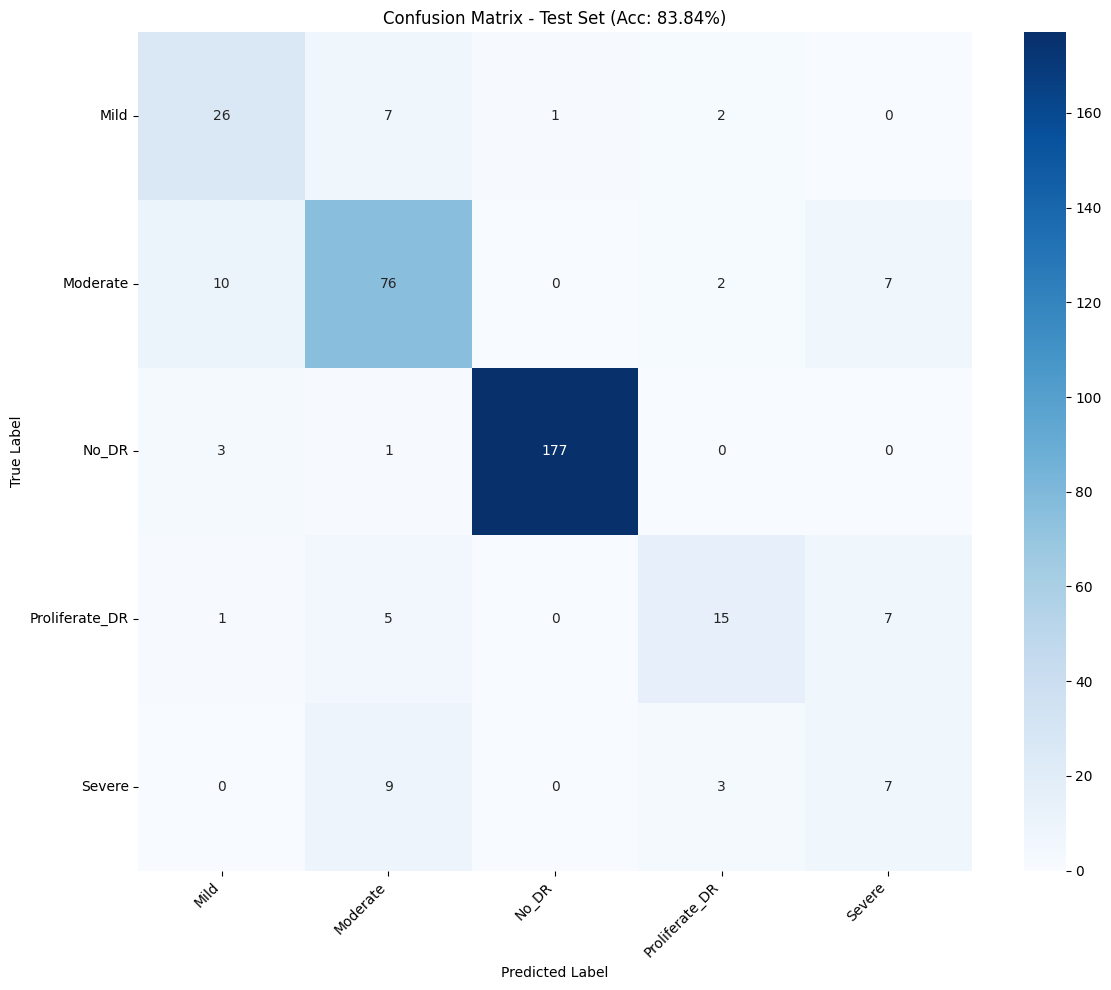

In [9]:

#%%
# Cell 9 — Final Testing & Evaluation
print("\n--- STARTING FINAL EVALUATION ON TEST SET ---")

# Find the best checkpoint, starting from 'full'
best_ckpt_path = ""
for f in ["best_full_triplet.pth", "best_partial_triplet.pth", "best_head_triplet.pth"]:
    p = os.path.join(config.SAVE_DIR, f)
    if os.path.exists(p):
        best_ckpt_path = p
        break

if not best_ckpt_path:
    print("No checkpoints found. Cannot evaluate.")
    # Exit or raise error
else:
    print(f"Loading best checkpoint for evaluation: {best_ckpt_path}")
    
    # Instantiate model skeleton
    eval_model = TripletHybridModel(
        num_classes=num_classes, 
        proj_dim=config.PROJ_DIM, 
        drop_rate=0.0 # No dropout for eval
    ).to(config.DEVICE)
    
    # Load weights
    eval_state = torch.load(best_ckpt_path, map_location=config.DEVICE)
    eval_model.load_state_dict(eval_state, strict=False)
    eval_model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        pbar = tqdm(test_loader, desc="Testing")
        for imgs, labels in pbar:
            imgs = imgs.to(config.DEVICE, non_blocking=True)
            labels = labels.to(config.DEVICE, non_blocking=True)
            with torch.cuda.amp.autocast():
                logits = eval_model(imgs)
            _, preds = torch.max(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # --- Metrics ---
    acc = accuracy_score(all_labels, all_preds)
    f1_mac = f1_score(all_labels, all_preds, average="macro")
    f1_wei = f1_score(all_labels, all_preds, average="weighted")
    
    print(f"\nTest Accuracy: {acc:.4f} ({acc*100:.2f}%)")
    print(f"Test Macro F1-Score: {f1_mac:.4f}")
    print(f"Test Weighted F1-Score: {f1_wei:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(
        all_labels, 
        all_preds, 
        target_names=test_dataset.classes, 
        digits=4
    ))

    # --- Confusion Matrix ---
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Test Set (Acc: {acc*100:.2f}%)")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save the confusion matrix plot
    cm_path = os.path.join(config.SAVE_DIR, "confusion_matrix_test.png")
    plt.savefig(cm_path)
    print(f"Saved confusion matrix to {cm_path}")
    plt.show()
